In [1]:
import pandas as pd
import pymc as pm
import arviz as az
import numpy as np

### Read Data

In [2]:
data = pd.read_csv("data/pass_rusher_features.csv")

In [3]:
data.y_smooth_pr.max()

51.77921803576193

In [4]:
from data.data_utils import process_data_play

In [5]:
processed_data = process_data_play(data[(data.nflId_pr == 41263) & (data.playId == 97) & (data.gameId == 2021090900)], partial_columns=["dx_smooth_pr", "dy_smooth_pr"], target_columns=["d2x_smooth_pr","d2y_smooth_pr"], position_columns=["x_smooth_pr", "y_smooth_pr"])

In [7]:
design_mat = processed_data[0]
target = processed_data[1]
gp_basis = processed_data[2]
dimension_id = processed_data[3]

In [9]:
design_mat[:,1] *= 2

### Fit Basic Christoffel Model

In [12]:
with pm.Model() as christoffel_model:
    sigma = pm.Exponential("sigma", 1, shape = (2,))

    length_scale = pm.Gamma("ls", 3, 7, shape = (2,))

    cov_func = pm.gp.cov.ExpQuad(2, ls=length_scale)
    gp = pm.gp.HSGP(m=[5, 5], c=4.0, cov_func=cov_func)
    basis_weights_x =  pm.math.stack([gp.prior(f"christoffel_symbol_x_{i}", X = gp_basis) for i in range(3)], axis = 0)
    basis_weights_y = pm.math.stack([gp.prior(f"christoffel_symbol_y_{i}", X = gp_basis) for i in range(3)], axis = 0)

    predicted_x = pm.math.sum(design_mat[dimension_id == 0,:] * basis_weights_x.T, axis = 1, keepdims=True)
    predicted_y = pm.math.sum(design_mat[dimension_id == 1,:] * basis_weights_y.T, axis = 1, keepdims=True)


    ### likelihood
    pm.Normal("likelihood_x", mu = predicted_x, 
              sigma = sigma[0], observed = -1 * target[dimension_id == 0,:])
    pm.Normal("likelihood_y", mu = predicted_y, 
              sigma = sigma[1], observed = -1 * target[dimension_id == 1,:])
    
with christoffel_model:
    trace = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, ls, christoffel_symbol_x_0_hsgp_coeffs_, christoffel_symbol_x_1_hsgp_coeffs_, christoffel_symbol_x_2_hsgp_coeffs_, christoffel_symbol_y_0_hsgp_coeffs_, christoffel_symbol_y_1_hsgp_coeffs_, christoffel_symbol_y_2_hsgp_coeffs_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1111 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [26]:
cs_x = az.summary(trace, var_names=[f"christoffel_symbol_x_{i}" for i in range(3)])[["mean"]].to_numpy().reshape(175,3)
cs_y = az.summary(trace, var_names=[f"christoffel_symbol_y_{i}" for i in range(3)])[["mean"]].to_numpy().reshape(175,3)

In [27]:
cs_x

array([[ 2.26 ,  2.26 ,  2.262],
       [ 2.265,  2.267,  2.265],
       [ 2.257,  2.237,  2.203],
       [ 2.15 ,  2.073,  1.967],
       [ 1.831,  1.662,  1.46 ],
       [ 1.227,  0.965,  0.682],
       [ 0.382,  0.075, -0.231],
       [-0.527, -0.805, -1.057],
       [-1.277, -1.461, -1.607],
       [-1.715, -1.787, -1.824],
       [-1.831, -1.812, -1.772],
       [-1.716, -1.648,  2.26 ],
       [ 2.26 ,  2.262,  2.265],
       [ 2.267,  2.265,  2.257],
       [ 2.237,  2.203,  2.15 ],
       [ 2.073,  1.967,  1.831],
       [ 1.662,  1.46 ,  1.227],
       [ 0.965,  0.682,  0.382],
       [ 0.075, -0.231, -0.527],
       [-0.805, -1.057, -1.277],
       [-1.461, -1.607, -1.715],
       [-1.787, -1.824, -1.831],
       [-1.812, -1.772, -1.716],
       [-1.648,  2.26 ,  2.26 ],
       [ 2.262,  2.265,  2.267],
       [ 2.265,  2.257,  2.237],
       [ 2.203,  2.15 ,  2.073],
       [ 1.967,  1.831,  1.662],
       [ 1.46 ,  1.227,  0.965],
       [ 0.682,  0.382,  0.075],
       [-0

## Plot Results

In [29]:
import matplotlib.pyplot as plt

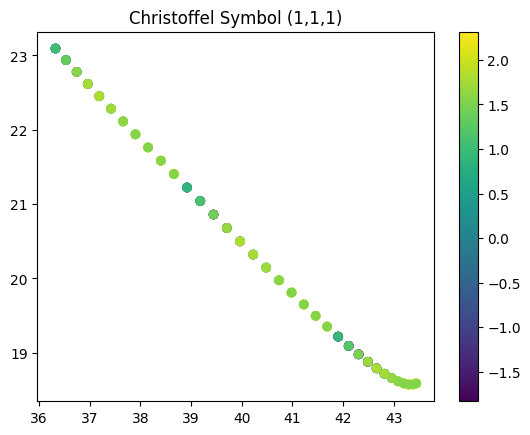

In [53]:
plt.scatter(gp_basis[:,0], gp_basis[:,1], c = cs_x[:,0],)
plt.title("Christoffel Symbol (1,1,1)")
plt.colorbar()

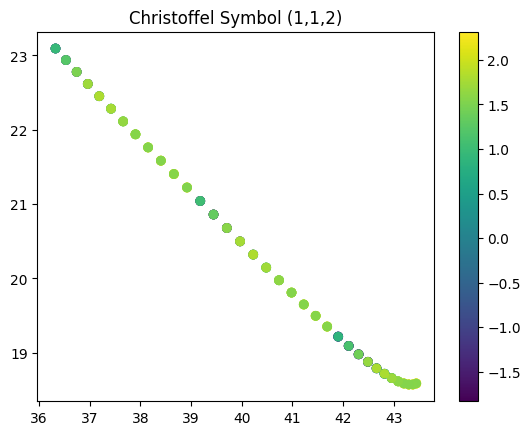

In [54]:
plt.scatter(gp_basis[:,0], gp_basis[:,1], c = cs_x[:,1])
plt.title("Christoffel Symbol (1,1,2)")
plt.colorbar()

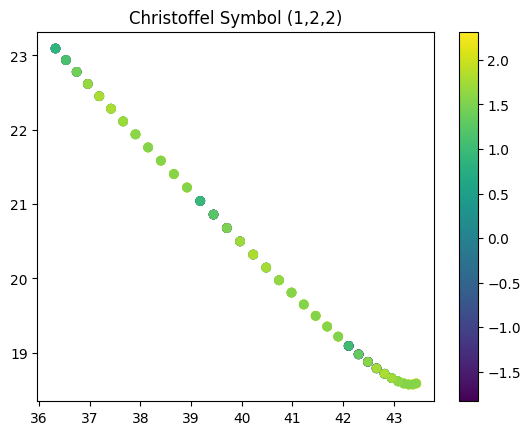

In [55]:
plt.scatter(gp_basis[:,0], gp_basis[:,1], c = cs_x[:,2])
plt.title("Christoffel Symbol (1,2,2)")
plt.colorbar()

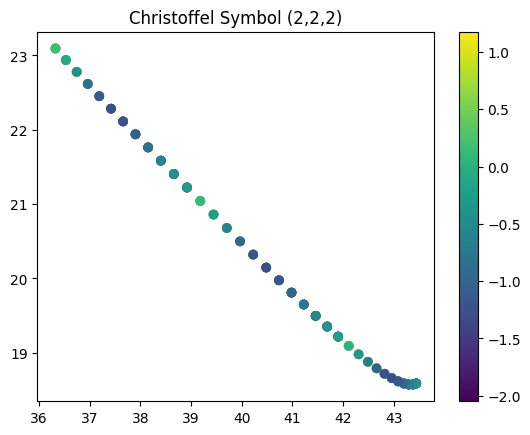

In [56]:
plt.scatter(gp_basis[:,0], gp_basis[:,1], c = cs_y[:,2])
plt.title("Christoffel Symbol (2,2,2)")
plt.colorbar()

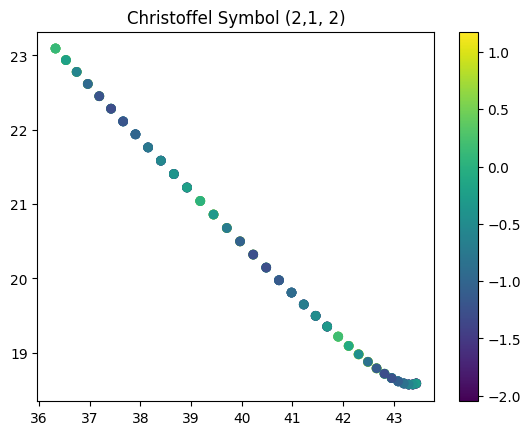

In [57]:
plt.scatter(gp_basis[:,0], gp_basis[:,1], c = cs_y[:,1])
plt.title("Christoffel Symbol (2,1, 2)")
plt.colorbar()

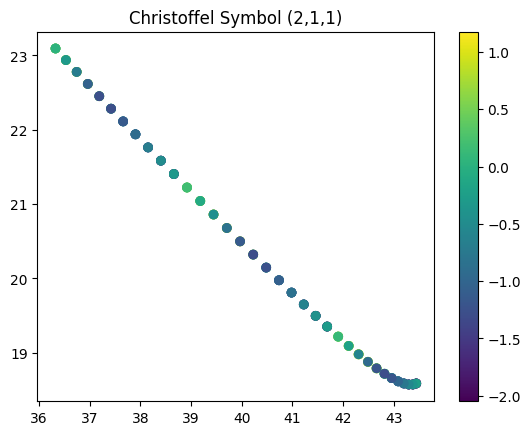

In [58]:
plt.scatter(gp_basis[:,0], gp_basis[:,1], c = cs_y[:,0])
plt.title("Christoffel Symbol (2,1,1)")
plt.colorbar()